In [1]:
!pip install git+https://github.com/hoyso48/tf-albumentations@main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hoyso48/tf-albumentations (to revision main) to /tmp/pip-req-build-e4692rj9
  Running command git clone -q https://github.com/hoyso48/tf-albumentations /tmp/pip-req-build-e4692rj9
     |████████████████████████████████| 1.1 MB 25.7 MB/s 
  Created wheel for tf-albumentations: filename=tf_albumentations-0.0.1-py3-none-any.whl size=16513 sha256=55efea95eaad858266eae16408b65ebc0dcd698a0b20f631ec797cdc9c314e95
  Stored in directory: /tmp/pip-ephem-wheel-cache-nr9t_3go/wheels/a8/81/e3/3e1c4593ccb5ecc19ab7ec385dddd0ad63fb036af46cd39837
Successfully built tf-albumentations


In [2]:
# !git clone https://github.com/hoyso48/tf-albumentations.git

In [3]:
# cd /content/tf-albumentations

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
import tensorflow_addons as tfa

import tf_albumentations
from tf_albumentations import transforms as A
from tf_albumentations.autoaugment import AutoAugment, RandAugment

In [5]:
import matplotlib

rgb_colors = {}
for name, hex in matplotlib.colors.cnames.items():
    rgb_colors[name] = matplotlib.colors.to_rgb(hex)

# rgb_colors = (np.array(list(rgb_colors.values()))*255).astype('int')
rgb_colors = list(rgb_colors.values())

def show(image, mask=None, bboxes=None, bgr_dict=rgb_colors):
    image = image.numpy()
    if mask is not None:
        msk = mask.numpy()

    H, W = image.shape[:2]
    col=1; row =1; idx=0
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(row, col, idx+1)

    img_ = image.copy()
    if bboxes is not None:
        for bbox, cls in zip(bboxes['bbox'], bboxes['label']):
            bgr = bgr_dict[cls]
            cv2.rectangle(img_, (int(bbox[1]*W), int(bbox[0]*H)), (int(bbox[3]*W), int(bbox[2]*H)), (bgr[0]*255, bgr[1]*255, bgr[2]*255), thickness=1)

            prob = 1
            text = '%d:%.2f' % (cls, prob)
            size, baseline = cv2.getTextSize(text,  cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, thickness=-1)
            text_w, text_h = size

            line_thickness = 1
            x1y1 = (int(bbox[1]*W), int(bbox[0]*H))
            x2y2 = (x1y1[0] + text_w + line_thickness, x1y1[1] + text_h + line_thickness + baseline)
            cv2.rectangle(img_, x1y1, x2y2, (bgr[0]*255, bgr[1]*255, bgr[2]*255), -1)
            cv2.putText(img_, text, (x1y1[0] + line_thickness, x1y1[1] + 2*baseline + line_thickness),
            cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4, color=(0, 0, 0), thickness=1, lineType=8)

    ax.imshow(img_)
    if mask is not None:
        ax.imshow(msk*255,alpha=.4)

    plt.show()

In [24]:
def decode_example_voc(example):
  image = tf.image.resize(example['image'], (256,256))
  image = tf.reshape(image, (256,256,3))

  bboxes = example['objects']['bbox']
  
  cls = example['objects']['label']

  return image, {'bbox':bboxes, 'label':cls}

In [26]:
ds = tfds.load('voc', split=['train[:1%]'])[0]
ds = ds.map(decode_example_voc)
ds

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})>

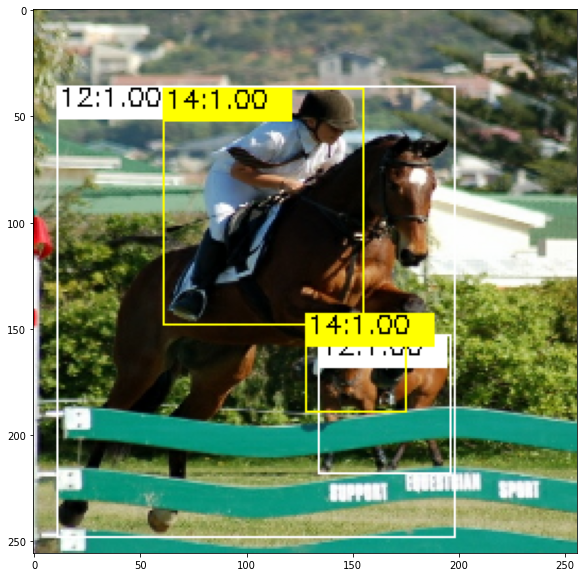

In [27]:
for x in ds:
  show(image=x[0]/255., bboxes=x[1])
  break

In [53]:
'''
A.Sequence: sequentially apply ops
A.Choice: apply ops from list of ops selected by np.random.choice
- with replace = True, sample ops with replacement.
- with sample weights, sample ops with corresponding weight(ops with higher weights are more likely to be sampled).
- with remain_order = True, remian order(given in list when creating A.Choice instance) while applyng ops
'''

transform = A.Sequence([
                        A.HorizontalFlip(p=0.5),
                        A.Scale(p=1, scale=(0.7,1.33)),
                        A.Choice([
                                  A.HSVJitter(p=1),
                                  A.Rotate(p=1),
                                  A.Shear(p=1),
                                  A.Translate(p=1),
                                  ], n=2),
                        ])
# transform = AutoAugment()
# transform = RandAugment()

In [54]:
ds = tfds.load('voc', split=['train[:1%]'])[0]
ds = ds.map(decode_example_voc)
ds = ds.map(lambda image, objects:transform(image=image, objects=objects))
ds = ds.map(lambda x: (x['image'], x['objects']))
ds

<MapDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})>

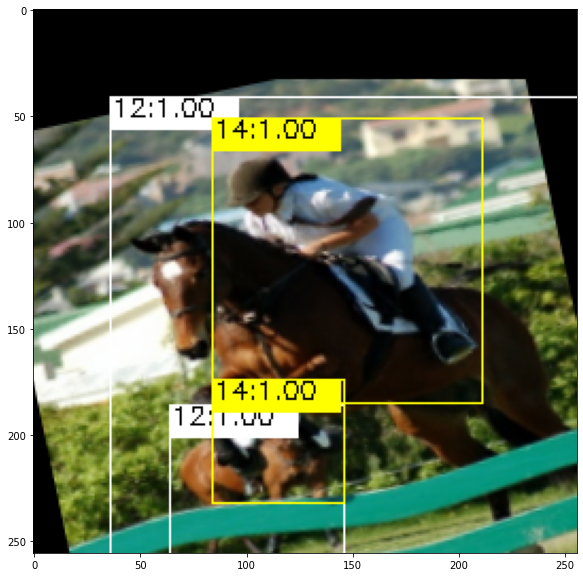

In [55]:
for x in ds:
  show(image=x[0]/255., bboxes=x[1])
  break

In [56]:
ds = tfds.load('oxford_iiit_pet:3.*.*', split=['train[:1%]'])[0]

In [57]:
def decode_example_oxf(example):
  image = tf.image.resize(example['image'], (256,256))
  image = tf.reshape(image, (256,256,3))

  mask = tf.image.resize(example['segmentation_mask'], (256,256), 'nearest')
  mask = tf.reshape(mask, (256,256,-1))[...,0]
  mask = tf.one_hot(mask, 3, axis=-1, dtype=tf.uint8)
  
  return image, mask

In [58]:
transform = A.Sequence([
                        A.HorizontalFlip(p=0.5),
                        A.Scale(p=1, scale=(0.7,1.33)),
                        A.Choice([
                                  A.HSVJitter(p=1),
                                  A.Rotate(p=1),
                                  A.Shear(p=1),
                                  A.Translate(p=1),
                                  ], n=2),
                        A.Choice([
                                  A.OpticalDistortion(p=1),
                                  A.GridDistortion(p=1),
                                  A.ElasticTransform(p=1),
                                  ], n=1)
                        ])

In [59]:
ds = tfds.load('oxford_iiit_pet:3.*.*', split=['train[:10%]'])[0]
ds = ds.map(decode_example_oxf)
ds = ds.map(lambda image, mask:transform(image=image, mask=mask))
ds = ds.map(lambda x: (x['image'], x['mask']))
ds

<MapDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None))>

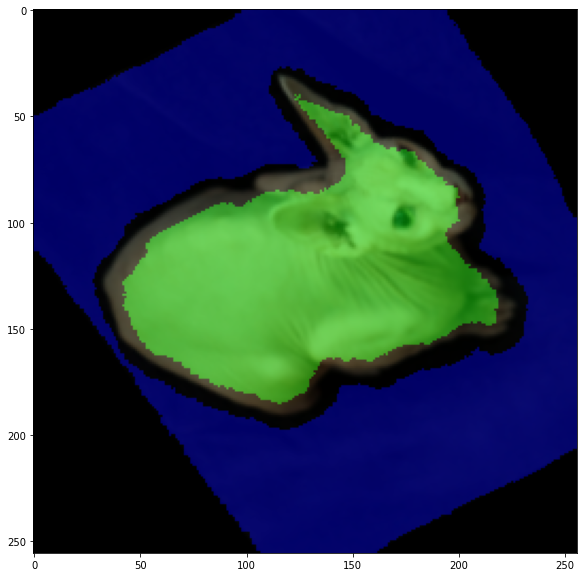

In [60]:
for x in ds:
  show(image=x[0]/255., mask=x[1])
  break